Filename:dbscan_tab_seperated.txt
Enter minimum number of points:16
Enter eps:0.5


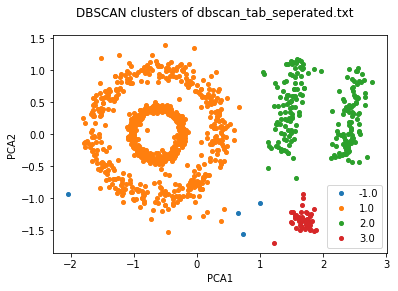

      Jaccard Coefficient:  0.4645531972421252
               Rand Index:  0.6726694214876033


In [27]:
import sys
import os
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from numpy import linalg as LA

def is_core_point(neighbor_points):
    if(len(neighbor_points) >= min_pts):
        return True
    return False

def get_neighbor_points(target_index):
    neighbor_points = []
    for row_index in range(len(data)):
        distance = 0
        for i in range(len(data[row_index])):
            distance += ((data[target_index][i] - data[row_index][i]) ** 2)
        if(sqrt(distance) <= eps):
            neighbor_points.append(row_index)
    return neighbor_points

def add_point_to_cluster(row_index,cluster_index):
    if cluster_index not in clusters.keys():
        clusters[cluster_index] = []
    clusters[cluster_index].append(row_index)

def get_density_reachable_points(neighbor_points,cluster_index,row_index):
    add_point_to_cluster(row_index,cluster_index)
    for point in neighbor_points:
        if point not in classified:
            classified.append(point)
            current_neighbor_points = get_neighbor_points(point)
            if(is_core_point(current_neighbor_points)):
                neighbor_points = list(set(neighbor_points).union(set(current_neighbor_points)))
                get_density_reachable_points(neighbor_points,cluster_index,row_index)
        check_point_in_cluster = False
        for key in clusters.keys():
            if point in clusters[key]:
                check_point_in_cluster = True
                break
        if not check_point_in_cluster:
            add_point_to_cluster(point,cluster_index)
    
def dbscan(data,classified,cluster_index):
    for row_index in range(len(data)):
        if row_index not in classified:
            classified.append(row_index)
            neighbor_points = get_neighbor_points(row_index)
            if is_core_point(neighbor_points):
                cluster_index += 1
                get_density_reachable_points(neighbor_points,cluster_index,row_index)
            else:
                noise.append(row_index)
                
file_name =input("Filename:")
# file_name = "cho.txt"
# file_name = "iyer.txt"
# file_name = "dbscan_tab_seperated.txt"

data = np.loadtxt(file_name, delimiter="\t",dtype='str')
data = np.asarray(data).astype(np.float)

ground_truth = data[:, 1]

data = np.delete(data,[0,1],axis=1)

min_pts=int(input("Enter minimum number of points:"))
eps=float(input("Enter eps:"))
# min_pts = 5
# eps = 1

clusters = {}
cluster_index = 0
classified = []
noise = []

dbscan(data,classified,cluster_index)

cluster_class = np.zeros(ground_truth.shape)
cluster_class.fill(-1)

for genes in list(clusters):
    class_list = np.unique(np.asarray(clusters[genes])).astype(int)
    cluster_class[class_list] = genes
    
################# PCA Visualization ################################################
data = np.loadtxt(file_name, delimiter="\t",dtype='str')
features_count = len(data[0])-1

data = np.asmatrix(data)
features = np.delete(data,[0,1],1)
features = features.astype(np.float)
labels = data[:, features_count]

mean_features = np.mean(features, axis=0)
adjusted_data = features - mean_features
covariance_matrix = np.cov(adjusted_data.T)

w, v = LA.eig(covariance_matrix)

w = w.argsort()[::-1][:2]
v = v[:,w]

principal_components = adjusted_data * v
principal_components = np.asarray(principal_components)

labels = cluster_class
df = pd.DataFrame(dict(xAxis=principal_components[:,0], yAxis=principal_components[:,1], label=labels))
diesase_groups = df.groupby('label')
    
fig, ax = plt.subplots()
fig.suptitle('DBSCAN clusters of ' + file_name)
for disease, diesase_group in diesase_groups:
    ax.plot(diesase_group.xAxis, diesase_group.yAxis, marker='o', linestyle='', ms=4, label=disease)

plt.xlabel('PCA1')
plt.ylabel('PCA2')
ax.legend()
plt.savefig('PCA_' + os.path.splitext(os.path.basename(file_name))[0] + ".png", dpi = 400)
plt.show()

################# Analysis ################################################
def get_incidence_matrix(labels):
    incidence_matrix = np.zeros((len(labels),len(labels)))
    for i in range(len(labels)):
        for j in range(len(labels)):
                incidence_matrix[i][j] = 1 if labels[i] == labels[j] else 0
    return incidence_matrix

def get_data_count(G, A):
    m11 = m00 = m10 = m01 = 0.0
    for i in range(len(G)):
        for j in range(len(G)):
            if G[i][j] == 1 and A[i][j] == 1:
                m11 += 1
            elif G[i][j] == 0 and A[i][j] == 0:
                m00 += 1
            elif G[i][j] == 0 and A[i][j] == 1:
                m10 += 1
            elif G[i][j] == 1 and A[i][j] == 0:
                m01 += 1
                
    return m11, m00, m10, m01

def jaccard(m11,m10,m01):
    return m11/(m11 + m10 + m01)

def rand(m00,m11,m10,m01):
    return (m00 + m11)/(m00 + m11 + m10 + m01)

# print(ground_truth)
# print(test_clusters)
ground_truth_matrix = get_incidence_matrix(ground_truth)
# print(ground_truth_matrix)
actual_cluster_matrix = get_incidence_matrix(cluster_class)
# print(tes)
m11,m00,m10,m01 = get_data_count(ground_truth_matrix, actual_cluster_matrix)
print('      Jaccard Coefficient: ', jaccard(m11,m10,m01))
print('               Rand Index: ', rand(m00,m11,m10,m01))